In [1]:
#Import general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import libraries useful for building the pipeline and join their branches
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


#import modules created for data preparation phase
import my_utils
import missing_val_imput
import feature_select
import preprocessing
import adhoc_transf

#import libraries for data preparation phase
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, StandardScaler


#import libraries from modelling phase
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

#to save model fit with GridSearchCV and avoid longer waits
import joblib


In [2]:
#Importing libs for explainability
from model import SurvSHAP

c:\Users\xdpemo\AppData\Local\anaconda3\envs\XAI\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\xdpemo\AppData\Local\anaconda3\envs\XAI\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta

In [3]:
#15.6.23 The target feature is dealing with death event and time
#Loading the dataset
path_data=r'heart_failure_clinical_records_dataset.csv'

df=pd.read_csv(path_data)
df.head()

#%%Characterizing the data set
target_features=['DEATH_EVENT','time']
numerical_feats=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium']
nominal_feats=['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
ordinal_feats=[]

len_numerical_feats=len(numerical_feats)
len_nominal_feats=len(nominal_feats)
len_ordinal_feats=len(ordinal_feats)

In [4]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


#Step 1 Solving wrong characters of dataset
###################################################################################################################

In [5]:
#%%
###################################################################################################################
#Step 1 Solving wrong characters of dataset
###################################################################################################################
#Set column id as index


# CKD case does only have misspellingCorrector
# df_content_solver=Pipeline([('fx1', misspellingCorrector()),
#                             ('fx2',function2()),
#                             ('fx3',function3())
# ])

#%%
df=adhoc_transf.ageRounder().fit_transform(df)
#my_utils.df_values(df)

#%%Performing numeric cast for numerical features
df.loc[:,numerical_feats]=adhoc_transf.Numeric_Cast_Column().fit_transform(df.loc[:,numerical_feats])
df[numerical_feats].dtypes


#%%Performing category cast for nominal features
df.loc[:,nominal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,nominal_feats])
df[nominal_feats].dtypes

#%%Performing category cast for ordinal features
df.loc[:,ordinal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,ordinal_feats])
df[ordinal_feats].dtypes

#%%
###################################################################################################################
##Step 1.1 Winsorization strategies to set the outliers to the values of 10 and 90 percentiles
####################################################################


def winsorize_percentiles(df, columns, lower_percentile, upper_percentile):
    for column in columns:
        lower_limit = df[column].quantile(lower_percentile/100)
        upper_limit = df[column].quantile(upper_percentile/100)
        df[column] = df[column].clip(lower_limit, upper_limit)
    return df

# Example usage

columns_to_winsorize = ['creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium',]
lower_percentile = 0
upper_percentile = 90

df = winsorize_percentiles(df, columns_to_winsorize, lower_percentile, upper_percentile)



>>>>>>>>Calling init() from ageRounder

>>>>>>>>Calling fit() from ageRounder

>>>>>>>>Calling transform() from ageRounder

>>>>>>>>Calling rounder

>>>>>>>>Calling init() from Numeric_Cast_Column

>>>>>>>>Calling fit() from Numeric_Cast_Column

>>>>>>>>Calling transform() from Numeric_Cast_Column

>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column

>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column



##Step 2 Train-Test splitting
###################################################################################################################

In [6]:
#%%
#15.6.2023
###################################################################################################################
##Step 2 Train-Test splitting
###################################################################################################################

#Split the dataset into train and test
#The stratificatin is made on the death_event
test_ratio_split=0.3
train_set,test_set=train_test_split(df, test_size=test_ratio_split, random_state=42, stratify=df['DEATH_EVENT'])

X_train=train_set.drop(target_features,axis=1)
y_train=train_set[target_features].copy()

X_test=test_set.drop(target_features,axis=1)
y_test=test_set[target_features].copy()

##Step 3 Preparing target feature (y) for survival analysis
###################################################################################################################


In [7]:
y_train['DEATH_EVENT']=y_train['DEATH_EVENT'].astype(bool)
y_test['DEATH_EVENT']=y_test['DEATH_EVENT'].astype(bool)

In [8]:
y_train=y_train.to_records(index=False)
y_test=y_test.to_records(index=False)

In [9]:
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
186,50.0,0,582.0,0,50,0,153000.0,0.6,134.0,0,0
258,45.0,1,66.0,1,25,0,233000.0,0.8,135.0,1,0
104,60.0,0,53.0,0,50,1,286000.0,2.1,141.2,0,0
161,45.0,1,130.0,0,35,0,174000.0,0.8,139.0,1,1
263,68.0,1,157.0,1,60,0,208000.0,1.0,140.0,0,0


#Survival analysis with Kaplan_meier

Text(0.5, 0, 'time $t$')

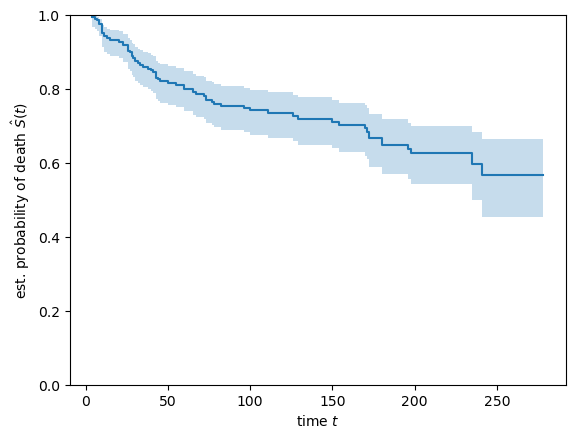

In [9]:
#%%
#Survival analysis with Kaplan_meier
from sksurv.nonparametric import kaplan_meier_estimator

time, survival_prob, conf_int = kaplan_meier_estimator(
    y_train["DEATH_EVENT"],y_train["time"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("est. probability of death $\hat{S}(t)$")
plt.xlabel("time $t$")

#Applying Multivariate Survival Model with Cox

Following the tutotial:https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#Survival-Data

In it they apply OneHotEncoder before fitting. We dont apply the OneHotEncoder to our nominal feature becuase they are already coded as 0 or 1


In [10]:
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

set_config(display="text")  # displays text representation of estimators
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)
pd.Series(estimator.coef_, index=X_train.columns)

age                         2.591337e-02
anaemia                     5.141853e-01
creatinine_phosphokinase    2.347872e-04
diabetes                    4.344261e-01
ejection_fraction          -3.234685e-02
high_blood_pressure         6.400365e-01
platelets                   2.288139e-08
serum_creatinine            1.350145e+00
serum_sodium               -2.792836e-02
sex                        -6.925393e-02
smoking                     4.124461e-01
dtype: float64

In [12]:
#Using the MinMax scaler, in theory using cox is not needed to Scaling the numerical value
# set_config(display="text")  # displays text representation of estimators
# X_train[numerical_feats]=MinMaxScaler().fit_transform(X_train[numerical_feats])
# estimator = CoxPHSurvivalAnalysis()
# estimator.fit(X_train, y_train)
# series=pd.Series(estimator.coef_, index=X_train.columns)
# print('Log hazard ratio with MinMaxScaler:\n', series )



In [13]:
X_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
186,50.0,0,582.0,0,50,0,153000.0,0.6,134.0,0,0
258,45.0,1,66.0,1,25,0,233000.0,0.8,135.0,1,0
104,60.0,0,53.0,0,50,1,286000.0,2.1,141.2,0,0
161,45.0,1,130.0,0,35,0,174000.0,0.8,139.0,1,1
263,68.0,1,157.0,1,60,0,208000.0,1.0,140.0,0,0


In [ ]:
#Using the StandarScaler, in theory using cox is not needed to Scaling the numerical value
# set_config(display="text")  # displays text representation of estimators
# X_train[numerical_feats]=StandardScaler().fit_transform(X_train[numerical_feats])
# estimator = CoxPHSurvivalAnalysis()
# estimator.fit(X_train, y_train)
# series=pd.Series(estimator.coef_, index=X_train.columns)
# print('Log hazard ratio with StandardScaler:\n', series )

In [ ]:
#It seems that the approach with the reasonable approach is the one without scaling

In [11]:
#Measuring the Performance of Survival Models
from sksurv.metrics import concordance_index_censored

prediction = estimator.predict(X_train)
result = concordance_index_censored(y_train["DEATH_EVENT"],y_train["time"], prediction)
result[0]

0.7437024018746339

In [12]:
#Feature Selection: Which Variable is Most Predictive?
import numpy as np


def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(X_train.values, y_train)
pd.Series(scores, index=X_train.columns).sort_values(ascending=False)

serum_creatinine            0.679408
ejection_fraction           0.623169
age                         0.585140
serum_sodium                0.580258
high_blood_pressure         0.559217
anaemia                     0.540617
smoking                     0.521334
sex                         0.516550
creatinine_phosphokinase    0.515183
diabetes                    0.507665
platelets                   0.495167
dtype: float64

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline


feat_select=ColumnTransformer([('numeric_pipe',feature_select.Feature_Selector(strategy='wrapper_RFECV'),numerical_feats),
                                    ('nominal_pipe',feature_select.Feature_Selector(strategy='wrapper_RFECV'),nominal_feats)
                                ])
pipe = Pipeline(
    [
        ("select", feat_select),
        ("model", CoxPHSurvivalAnalysis()),
    ]
)

pipe.get_params().keys()


>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector


dict_keys(['memory', 'steps', 'verbose', 'select', 'model', 'select__n_jobs', 'select__remainder', 'select__sparse_threshold', 'select__transformer_weights', 'select__transformers', 'select__verbose', 'select__verbose_feature_names_out', 'select__numeric_pipe', 'select__nominal_pipe', 'select__numeric_pipe__k_out_features', 'select__numeric_pipe__rfe_estimator', 'select__numeric_pipe__strategy', 'select__nominal_pipe__k_out_features', 'select__nominal_pipe__rfe_estimator', 'select__nominal_pipe__strategy', 'model__alpha', 'model__n_iter', 'model__ties', 'model__tol', 'model__verbose'])

##Step 5 Initializing model estimators
###################################################################################################################

In [14]:
#Initializing models with the best ones hyperparameters for the NON standardscaler approach
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis, ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import ExtraSurvivalTrees
from sksurv.svm import FastSurvivalSVM


random_state=42
cox=CoxPHSurvivalAnalysis()
cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio='auto', fit_baseline_model=True)
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state)
gboost = GradientBoostingSurvivalAnalysis(n_estimators=90, learning_rate=0.1, max_depth=1, random_state=random_state)
gboost_wise = ComponentwiseGradientBoostingSurvivalAnalysis(n_estimators=90, learning_rate=1.0, random_state=random_state)
extra=ExtraSurvivalTrees(n_estimators=100, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state)
svm=FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=random_state)






### Get the best model with an overall GridSearch throughout all the estimators

In [ ]:
#Get the best model with an overall GridSearch throughout all the estimators
from sklearn.model_selection import GridSearchCV, KFold
import joblib


param_grid = {'select__numeric_pipe__k_out_features':[*range(1,len_numerical_feats+1)],
                'select__numeric_pipe__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                'select__nominal_pipe__k_out_features':[*range(1,len_nominal _feats+1)],
                'select__nominal_pipe__strategy':['filter_cat','filter_mutinf','wrapper_RFE'],
                'model':[cox,cox_elastic_net,rsf,gboost,gboost_wise,extra,svm]
            }
cv = KFold(n_splits=5, random_state=1, shuffle=True)
gcv = GridSearchCV(pipe, param_grid, cv=cv)
gcv.fit(X_train, y_train)

#Saving the model
joblib.dump(gcv, r'GridSearchCV_results\HF_survival\gcv_survival.pkl', compress=1)


In [ ]:
results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
results.loc[:, ~results.columns.str.endswith("_time")]
results.to_excel(r'GridSearchCV_results\HF_survival\gcv_survival.xlsx', index=True)

### For loop for iterate the grid search over each of the model and thus calculate the different metrics

In [ ]:
#For loop for iterate the grid search over each of the model and thus calculate the different metrics
from sklearn.model_selection import GridSearchCV, KFold
import joblib

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

hf_times=np.arange(y_test['time'].min(), y_test['time'].max(), 10)

columns_names=['model','params','c_index','c_index_ipcw','model_mean_auc','brier_score']
test_results_rows=[]

#for model in [cox,cox_elastic_net,rsf,gboost,gboost_wise,extra,svm]:
for model in [gboost,extra]:
    pipe = Pipeline([("select", feat_select),("model", model)])
    model_name=str(model).split("(", 1)[0]

    param_grid = {'select__numeric_pipe__k_out_features':[*range(1,len_numerical_feats+1)],
                'select__numeric_pipe__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                'select__nominal_pipe__k_out_features':[*range(1,len_nominal_feats+1)],
                'select__nominal_pipe__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
    }

    # param_grid = {'select__numeric_pipe__k_out_features':[*range(1,3)],
    #             'select__numeric_pipe__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
    #             'select__nominal_pipe__k_out_features':[*range(1,3)],
    #             'select__nominal_pipe__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
    # }

    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    gcv = GridSearchCV(pipe, param_grid, cv=cv)
    gcv.fit(X_train, y_train)

    #Saving the model
    joblib.dump(gcv, r'GridSearchCV_results\HF_survival\gcv_survival_'+model_name+'.pkl', compress=1)
    #saving the grid search results
    results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
    results.loc[:, ~results.columns.str.endswith("_time")]
    results.to_excel(r'GridSearchCV_results\HF_survival\gcv_survival_'+model_name+'.xlsx', index=True)

    pipe.set_params(**gcv.best_params_)
    pipe.fit(X_train, y_train)
    
    risk_scores=pipe.predict(X_test)

    #Calculating metric concordance_index_censored with the test set
    c_index=concordance_index_censored(y_test["DEATH_EVENT"], y_test["time"], risk_scores)[0]

    #Calculating metric cconcordance_index_ipcw
    c_index_ipcw=concordance_index_ipcw(y_train,y_test,risk_scores)[0]

    #Calculating metric cumulative_dynamic_auc
    model_auc, model_mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_scores, hf_times)

    #Calcultating Brier score
    if model_name!='FastSurvivalSVM':
        survs = pipe.predict_survival_function(X_test)
        preds = np.asarray([[fn(t) for t in hf_times] for fn in survs])
        brier_score= integrated_brier_score(y_train, y_test, preds, hf_times)
    else:
        brier_score='NaN'

    results={'model':model_name,
            'params':pipe.get_params(),
            'c_index':c_index,
            'c_index_ipcw':c_index_ipcw,
            'model_mean_auc':model_mean_auc,
            'brier_score':brier_score}
    
    test_results_rows.append(results)
    
test_results=pd.DataFrame(test_results_rows)
test_results.to_excel(r'GridSearchCV_results\HF_survival\test_results_.xlsx', index=True)






In [ ]:
#Load the model
pipe_best = Pipeline(
    [
        ("select", feat_select),
        ("model", extra),
    ]
)
best_model=joblib.load('GridSearchCV_results\HF_survival\gcv_survival_ExtraSurvivalTrees.pkl')
pipe_best.set_params(**best_model.best_params_)
pipe_best.fit(X_train, y_train)


In [ ]:
#selected_features = pipe_best.named_steps['select'].named_steps['numeric_pipe'].get_support()

numeric_selector = pipe_best.named_steps['select'].transformers_[0][1]
nominal_selector = pipe_best.named_steps['select'].transformers_[1][1]
columns=numerical_feats+nominal_feats
num_mask=numeric_selector.feat_sel.get_support()
nom_mask=nominal_selector.feat_sel.get_support()
columns_mask=np.concatenate((num_mask, nom_mask))
filtered_columns = np.array(columns)[columns_mask]
print('columns', filtered_columns)


In [ ]:
pd.Series(final_estimator.coef_, index=X_train.columns[transformer.get_support()])

### GridSearchCV with the ExtraTree with the best parameters given my the foor loop over the iterator.

In [ ]:
# The best model with GridSearchCV for extra tree is different from the one produced by the overall GridSearchCV

from sklearn.model_selection import GridSearchCV, KFold
import joblib

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

hf_times=np.arange(y_test['time'].min(), y_test['time'].max(), 10)

columns_names=['model','params','c_index','c_index_ipcw','model_mean_auc','brier_score']
test_results_rows=[]

#for model in [cox,cox_elastic_net,rsf,gboost,gboost_wise,extra,svm]:
for model in [extra]:
    pipeExtra = Pipeline([("select", feat_select),("model", model)])
    model_name=str(model).split("(", 1)[0]

    param_grid = {'select__numeric_pipe__k_out_features':[4],
                'select__numeric_pipe__strategy':['filter_mutinf'],
                'select__nominal_pipe__k_out_features':[1],
                'select__nominal_pipe__strategy':['filter_mutinf']
    }

    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    gcv = GridSearchCV(pipeExtra, param_grid, cv=cv)
    gcv.fit(X_train, y_train)

    #Saving the model
    joblib.dump(gcv, r'GridSearchCV_results\HF_survival\gcv_survival_'+model_name+'_bestC-Interpret.pkl', compress=1)
    #saving the grid search results
    results = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
    results.loc[:, ~results.columns.str.endswith("_time")]
    #results.to_excel(r'GridSearchCV_results\HF_survival\gcv_survival_'+model_name+'.xlsx', index=True)

    pipeExtra.set_params(**gcv.best_params_)
    pipeExtra.fit(X_train, y_train)
    
    risk_scores=pipeExtra.predict(X_test)

    #Calculating metric concordance_index_censored with the test set
    c_index=concordance_index_censored(y_test["DEATH_EVENT"], y_test["time"], risk_scores)[0]

    #Calculating metric cconcordance_index_ipcw
    c_index_ipcw=concordance_index_ipcw(y_train,y_test,risk_scores)[0]

    #Calculating metric cumulative_dynamic_auc
    model_auc, model_mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_scores, hf_times)

    #Calcultating Brier score
    if model_name!='FastSurvivalSVM':
        survs = pipeExtra.predict_survival_function(X_test)
        preds = np.asarray([[fn(t) for t in hf_times] for fn in survs])
        brier_score= integrated_brier_score(y_train, y_test, preds, hf_times)
    else:
        brier_score='NaN'

    results={'model':model_name,
            'params':pipeExtra.get_params(),
            'c_index':c_index,
            'c_index_ipcw':c_index_ipcw,
            'model_mean_auc':model_mean_auc,
            'brier_score':brier_score}
    
    test_results_rows.append(results)
    
test_results=pd.DataFrame(test_results_rows)
#test_results.to_excel(r'GridSearchCV_results\HF_survival\test_results_.xlsx', index=True)

In [ ]:
#Get the most important features of the ExtraTree fitted with the following params
#{'select__nominal_pipe__k_out_features': 1, 'select__nominal_pipe__strategy': 'filter_mutinf', 
#'select__numeric_pipe__k_out_features': 4, 'select__numeric_pipe__strategy': 'filter_mutinf'}
numeric_selector = pipeExtra.named_steps['select'].transformers_[0][1]
nominal_selector = pipeExtra.named_steps['select'].transformers_[1][1]
columns=numerical_feats+nominal_feats
num_mask=numeric_selector.feat_sel.get_support()
nom_mask=nominal_selector.feat_sel.get_support()
columns_mask=np.concatenate((num_mask, nom_mask))
filtered_columns = np.array(columns)[columns_mask]
print('columns', filtered_columns)

#The result is
#columns ['creatinine_phosphokinase' 'ejection_fraction' 'serum_creatinine'
# 'serum_sodium' 'diabetes']


In [ ]:
X_test[filtered_columns]

#### Exploring the explainability analysis of ExtraTree

In [27]:
# Explore explainability with SHAP, fit the estimator with the resultant variables selection
import shap
filtered_columns=['creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine',
 'serum_sodium', 'diabetes']
X_train_feat_sel=X_train[filtered_columns]
X_test_feat_sel=X_test[filtered_columns]

extra.fit(X_train_feat_sel,y_train)
#shap_values=shap.KernelExplainer(extra,X_train_feat_sel).shap_values(X_train_feat_sel)
##ExtraSurvivalTree does not work

ExtraSurvivalTrees(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                   random_state=42)

In [28]:
X_train_feat_sel

,creatinine_phosphokinase,ejection_fraction,serum_creatinine,serum_sodium,diabetes
186,582.0,50,0.60,134.0,0
258,66.0,25,0.80,135.0,1
104,53.0,50,2.10,141.2,0
161,130.0,35,0.80,139.0,0
263,157.0,60,1.00,140.0,1
...,...,...,...,...,...
134,1203.8,35,1.18,137.0,0
229,211.0,25,1.20,134.0,0
74,582.0,20,1.20,134.0,0
177,69.0,50,1.00,140.0,0


In [29]:
#Employ SurvSHAP library
surv_train=extra.predict_survival_function(X_train_feat_sel, return_array=True)
surv_val=extra.predict_survival_function(X_train_feat_sel, return_array=True)
surv_test=extra.predict_survival_function(X_test_feat_sel, return_array=True)
event_times=extra.unique_times_

#Prepare Data for Explanation
xte_data = (X_train_feat_sel, y_train['time'], y_train['DEATH_EVENT'],
            X_train_feat_sel, y_train['time'], y_train['DEATH_EVENT'],            
            X_test_feat_sel, y_test['time'], y_test['DEATH_EVENT'])

#Prepare the Survival Curves for Explanation
survival_curves = (surv_train, surv_val, surv_test)

shape: 118


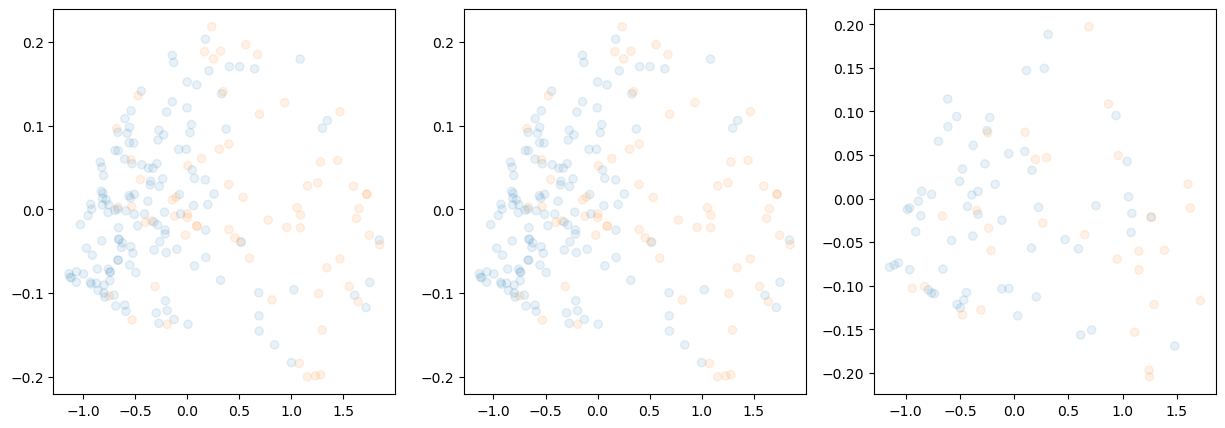

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

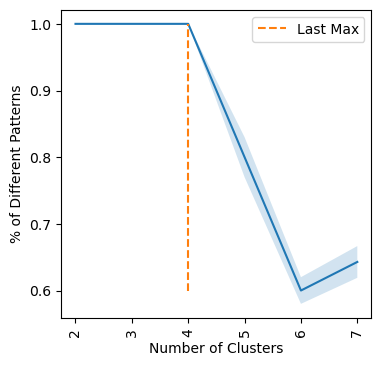

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


<Figure size 500x500 with 0 Axes>

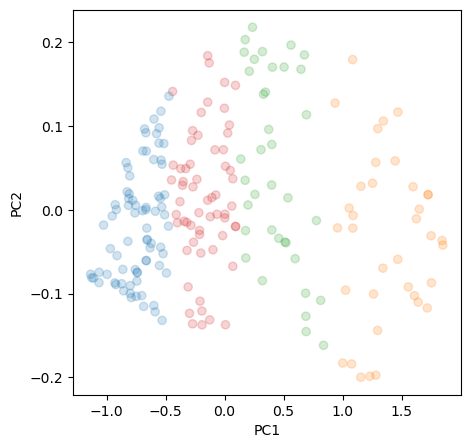

<Figure size 500x500 with 0 Axes>

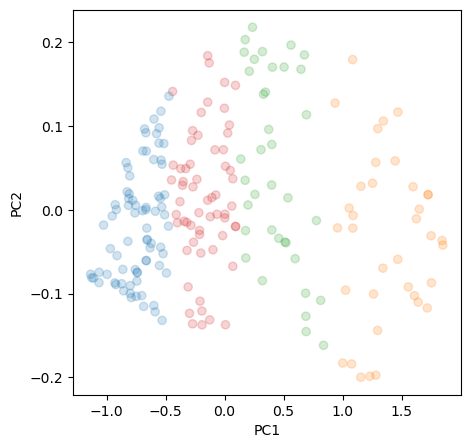

<Figure size 500x500 with 0 Axes>

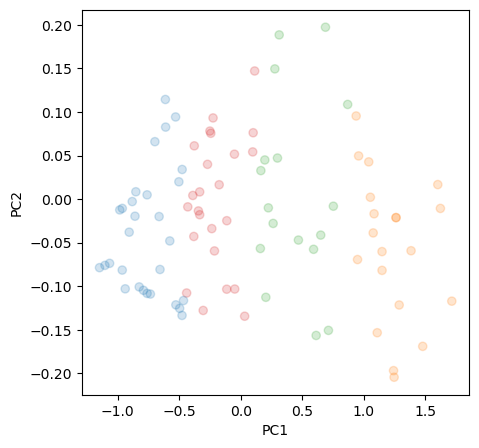

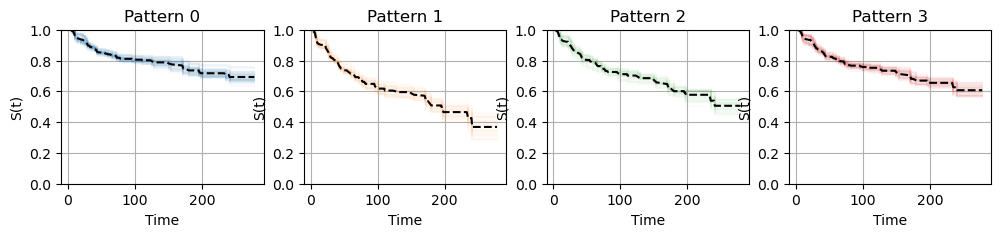

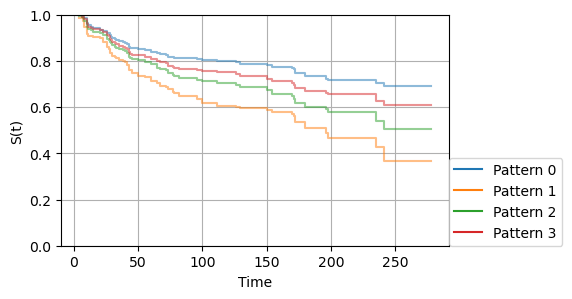

In [30]:
explainer = SurvSHAP(prefix_name='flchain_sub1_example', max_depth=15)
explainer.fit(xte_data=xte_data, survival_curves=survival_curves, event_times=event_times)

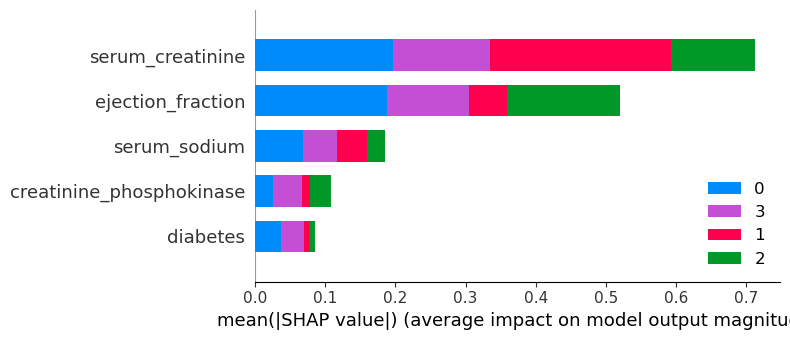

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


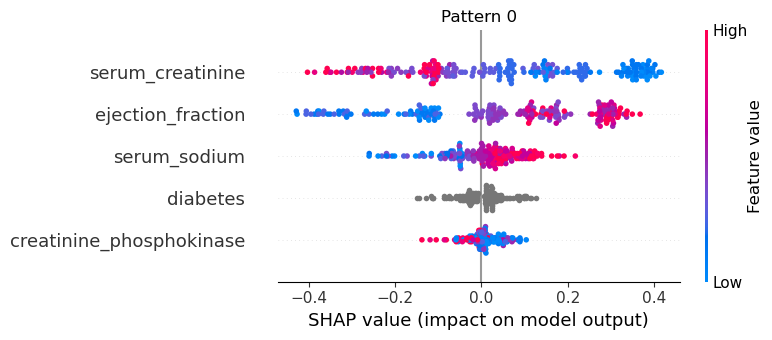

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


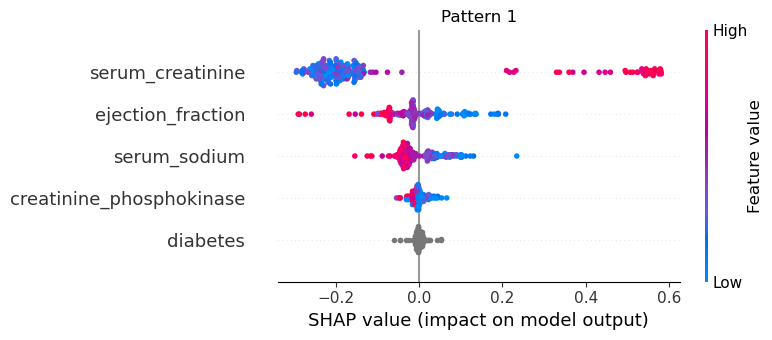

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


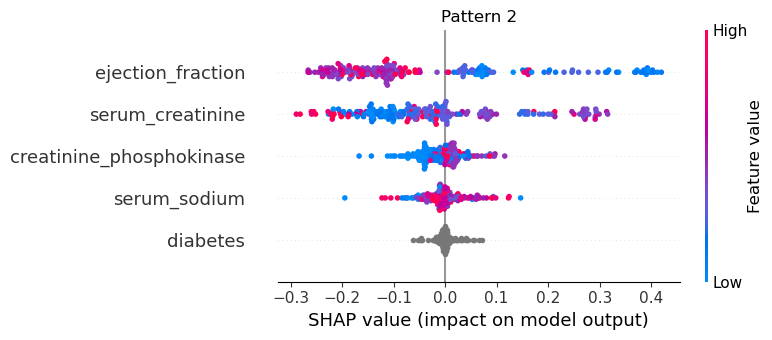

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


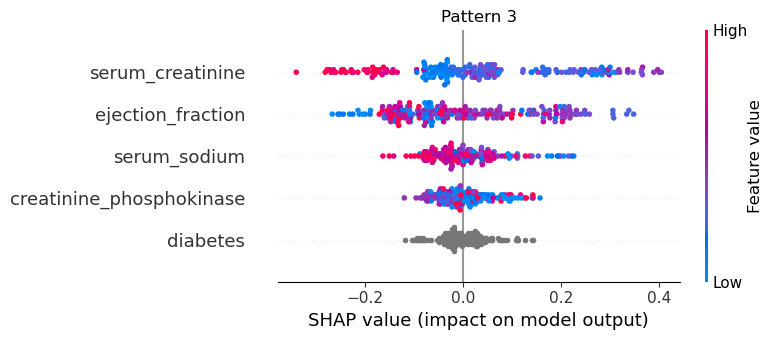

In [31]:
shap_values_train = explainer.explain(x=X_train_feat_sel, features_names_list=filtered_columns, suffex='train')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


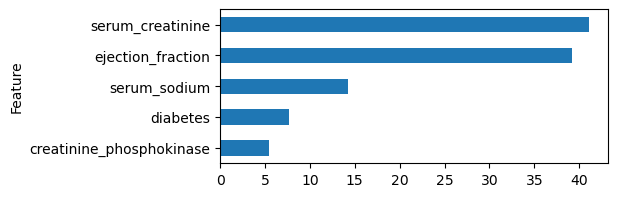

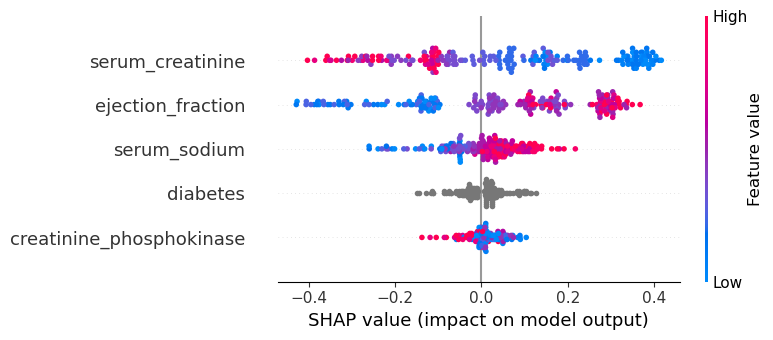

In [32]:
pattern = 0
feature_importnce_df = pd.DataFrame(zip(filtered_columns, np.abs(explainer.shap_values[pattern]).sum(axis=0)), columns=['Feature', 'Importance'])
feature_importnce_df.set_index('Feature', inplace=True)

plt.figure(figsize=(5, 2))
feature_importnce_df.sort_values('Importance')['Importance'].plot.barh()
plt.figure()
shap.summary_plot(explainer.shap_values[pattern], X_train_feat_sel, feature_names=filtered_columns, show=False)

In [ ]:
X_train_feat_sel

### Exploring the best 10 results of every estimator we discover the most balanced c_index interpretability is gcv_survival_GradientBoostingSurvivalAnalysis with the params

In [18]:
#Exploring the best 10 results of every estimator we discover the most balanced c_index interpretability is 
#gcv_survival_GradientBoostingSurvivalAnalysis with the params
#{'select__nominal_pipe__k_out_features': 2, 'select__nominal_pipe__strategy': 'filter_mutinf',
# 'select__numeric_pipe__k_out_features': 2, 'select__numeric_pipe__strategy': 'filter_mutinf'}
from sklearn.model_selection import GridSearchCV, KFold
import joblib

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

hf_times=np.arange(y_test['time'].min(), y_test['time'].max(), 10)

columns_names=['model','params','c_index','c_index_ipcw','model_mean_auc','brier_score']
test_results_rows=[]

#for model in [cox,cox_elastic_net,rsf,gboost,gboost_wise,extra,svm]:
for model in [gboost]:
    pipeGBoost = Pipeline([("select", feat_select),("model", model)])
    model_name=str(model).split("(", 1)[0]

    param_grid = {'select__numeric_pipe__k_out_features':[2],
                'select__numeric_pipe__strategy':['filter_mutinf'],
                'select__nominal_pipe__k_out_features':[2],
                'select__nominal_pipe__strategy':['filter_mutinf']
    }

    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    gcv = GridSearchCV(pipeGBoost, param_grid, cv=cv)
    gcv.fit(X_train, y_train)

    #Saving the model
    joblib.dump(gcv, r'GridSearchCV_results\HF_survival\gcv_survival_'+model_name+'_bestBalanced.pkl', compress=1)
    #saving the grid search results
    results_gcv = pd.DataFrame(gcv.cv_results_).sort_values(by="mean_test_score", ascending=False)
    results_gcv.loc[:, ~results_gcv.columns.str.endswith("_time")]
    results_gcv.to_excel(r'GridSearchCV_results\HF_survival\gcv_survival_'+model_name+'_bestBalanced.xlsx', index=True)

    pipeGBoost.set_params(**gcv.best_params_)
    pipeGBoost.fit(X_train, y_train)
    
    risk_scores=pipeGBoost.predict(X_test)

    #Calculating metric concordance_index_censored with the test set
    c_index=concordance_index_censored(y_test["DEATH_EVENT"], y_test["time"], risk_scores)[0]

    #Calculating metric cconcordance_index_ipcw
    c_index_ipcw=concordance_index_ipcw(y_train,y_test,risk_scores)[0]

    #Calculating metric cumulative_dynamic_auc
    model_auc, model_mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_scores, hf_times)

    #Calcultating Brier score
    if model_name!='FastSurvivalSVM':
        survs = pipeGBoost.predict_survival_function(X_test)
        preds = np.asarray([[fn(t) for t in hf_times] for fn in survs])
        brier_score= integrated_brier_score(y_train, y_test, preds, hf_times)
    else:
        brier_score='NaN'

    results={'model':model_name,
            'params':pipe.get_params(),
            'c_index':c_index,
            'c_index_ipcw':c_index_ipcw,
            'model_mean_auc':model_mean_auc,
            'brier_score':brier_score}
    
    test_results_rows.append(results)
    
test_results=pd.DataFrame(test_results_rows)
test_results.to_excel(r'GridSearchCV_results\HF_survival\test_results_'+model_name+'_bestBalanced.xlsx', index=True)



>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling fit() from Feature_Selector

>>>>>>>>Calling transform() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling fit() from Feature_Selector

>>>>>>>>Calling transform() from Feature_Selector

>>>>>>>>Calling transform() from Feature_Selector

>>>>>>>>Calling transform() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling fit() from Feature_Selector

>>>>>>>>Calling transform() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling fit() from Feature_Selector

>>>>>>>>Calling transform() from Feature_Selector

>>>>>>>>Calling transform() from Feature_Selector

>>

In [19]:
#Get the most important features of the ExtraTree fitted with the following params
#{'select__nominal_pipe__k_out_features': 1, 'select__nominal_pipe__strategy': 'filter_mutinf', 
#'select__numeric_pipe__k_out_features': 4, 'select__numeric_pipe__strategy': 'filter_mutinf'}
numeric_selector = pipeGBoost.named_steps['select'].transformers_[0][1]
nominal_selector = pipeGBoost.named_steps['select'].transformers_[1][1]
columns=numerical_feats+nominal_feats
num_mask=numeric_selector.feat_sel.get_support()
nom_mask=nominal_selector.feat_sel.get_support()
columns_mask=np.concatenate((num_mask, nom_mask))
filtered_columns = np.array(columns)[columns_mask]
print('columns', filtered_columns)

columns ['ejection_fraction' 'serum_creatinine' 'diabetes' 'sex']


#### Exploring the explainability analysis of GradientBoosting


In [19]:
filtered_columns=['ejection_fraction', 'serum_creatinine',
 'diabetes', 'sex']

X_train_feat_sel=X_train[filtered_columns]
X_test_feat_sel=X_test[filtered_columns]
X_train_feat_sel['diabetes']=X_train_feat_sel['diabetes'].astype(float)
X_train_feat_sel['sex']=X_train_feat_sel['sex'].astype(float)
X_test_feat_sel['diabetes']=X_test_feat_sel['diabetes'].astype(float)
X_test_feat_sel['diabetes']=X_test_feat_sel['diabetes'].astype(float)

gboost.fit(X_train_feat_sel,y_train)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

GradientBoostingSurvivalAnalysis(max_depth=1, n_estimators=90, random_state=42)

In [20]:
#Employ SurvSHAP library
surv_train=gboost.predict_survival_function(X_train_feat_sel, return_array=True)
surv_val=gboost.predict_survival_function(X_train_feat_sel, return_array=True)
surv_test=gboost.predict_survival_function(X_test_feat_sel, return_array=True)
event_times=gboost.unique_times_

#Prepare Data for Explanation
xte_data = (X_train_feat_sel, y_train['time'], y_train['DEATH_EVENT'],
            X_train_feat_sel, y_train['time'], y_train['DEATH_EVENT'],            
            X_test_feat_sel, y_test['time'], y_test['DEATH_EVENT'])

#Prepare the Survival Curves for Explanation
survival_curves = (surv_train, surv_val, surv_test)

shape: 118


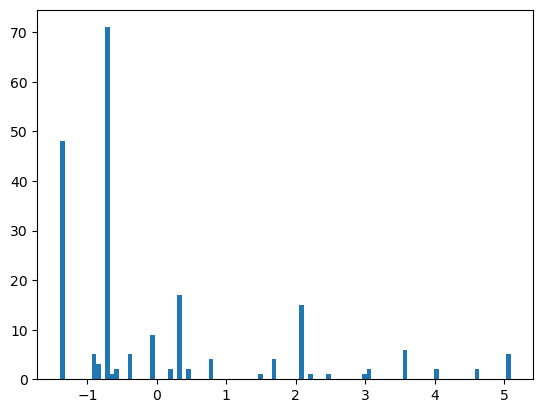

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than

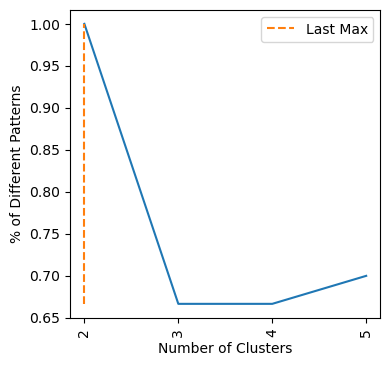

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.


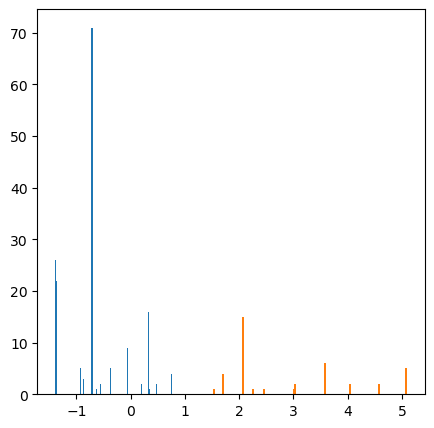

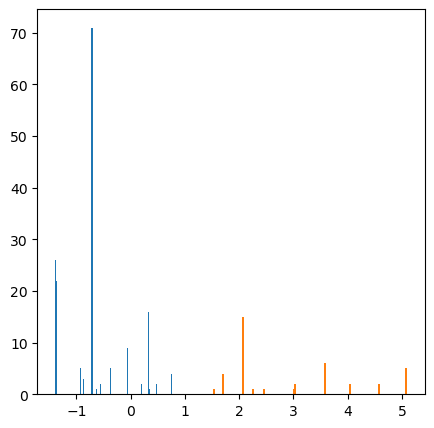

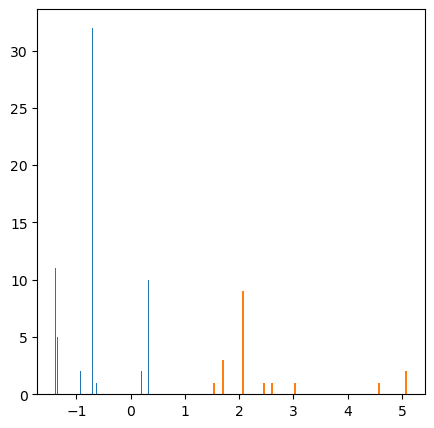

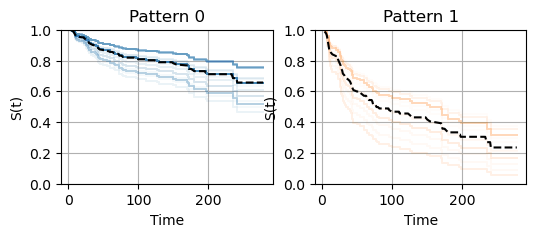

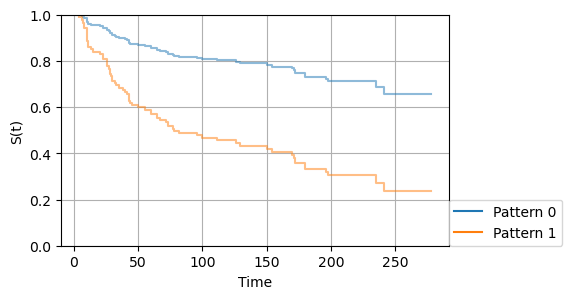

In [21]:
explainer = SurvSHAP(prefix_name='flchain_sub1_example', max_depth=15)
explainer.fit(xte_data=xte_data, survival_curves=survival_curves, event_times=event_times)

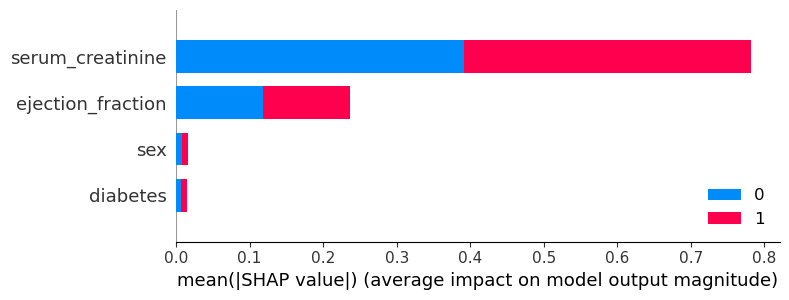

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


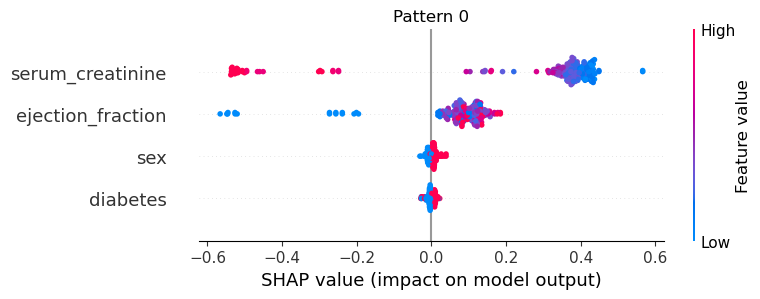

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


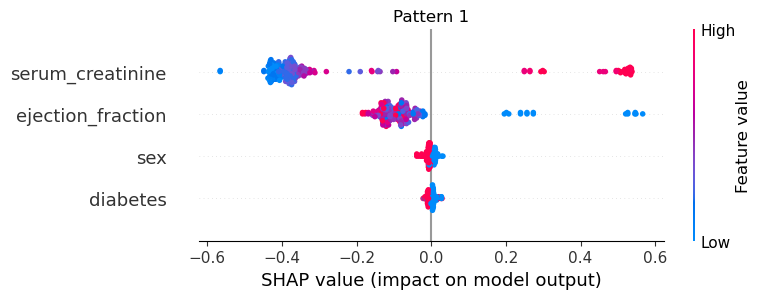

In [22]:
shap_values_train = explainer.explain(x=X_train_feat_sel, features_names_list=filtered_columns, suffex='train')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


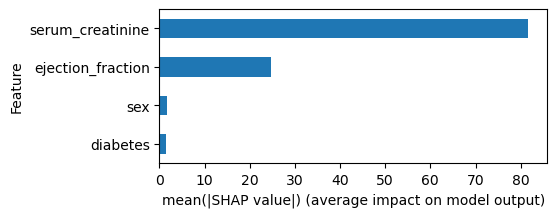

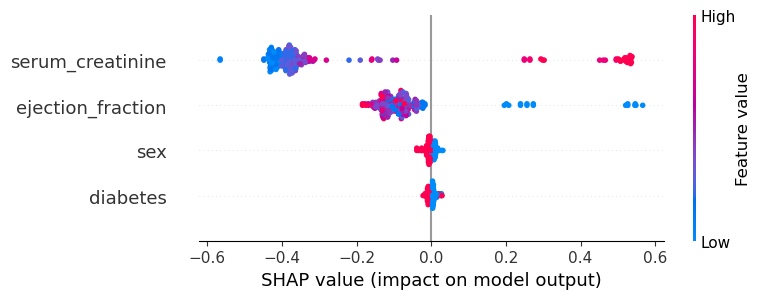

In [26]:

import shap
pattern = 1
feature_importnce_df = pd.DataFrame(zip(filtered_columns, np.abs(explainer.shap_values[pattern]).sum(axis=0)), columns=['Feature', 'Importance'])
feature_importnce_df.set_index('Feature', inplace=True)

plt.figure(figsize=(5, 2))
feature_importnce_df.sort_values('Importance')['Importance'].plot.barh()
plt.xlabel('mean(|SHAP value|) (average impact on model output)')
plt.figure()
shap.summary_plot(explainer.shap_values[pattern], X_train_feat_sel, feature_names=filtered_columns, show=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


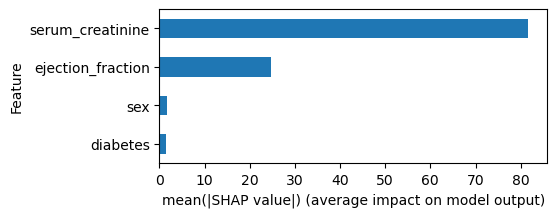

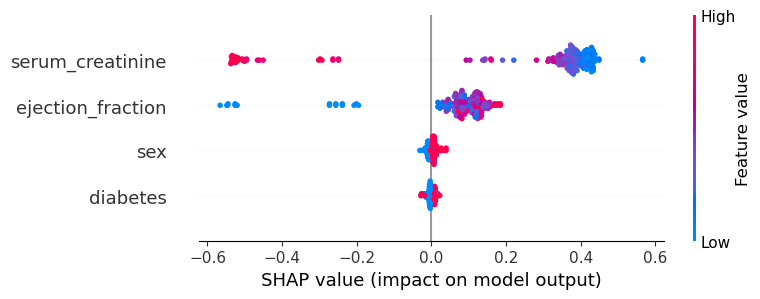

In [27]:

import shap
pattern = 0
feature_importnce_df = pd.DataFrame(zip(filtered_columns, np.abs(explainer.shap_values[pattern]).sum(axis=0)), columns=['Feature', 'Importance'])
feature_importnce_df.set_index('Feature', inplace=True)

plt.figure(figsize=(5, 2))
feature_importnce_df.sort_values('Importance')['Importance'].plot.barh()
plt.xlabel('mean(|SHAP value|) (average impact on model output)')
plt.figure()
shap.summary_plot(explainer.shap_values[pattern], X_train_feat_sel, feature_names=filtered_columns, show=False)

In [ ]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

x_test_imputed=X_test.loc[:,numerical_feats]

for i, col in enumerate(numerical_feats):
    plot_cumulative_dynamic_auc(x_test_imputed[:, i], col, color=f"C{i}")
    ret = concordance_index_ipcw(y_train, y_test, x_test_imputed[:, i], tau=times[-1])

In [ ]:
y_test['time'].min()

In [ ]:
#Evaluate a Model's prediction by using the cumulative dynamic auc

from sksurv.linear_model import CoxPHSurvivalAnalysis
cox_ph=CoxPHSurvivalAnalysis()
cox_ph.fit(X_train,y_train)

hf_times=np.arange(7, 285, 10)

cox_ph_risk_scores=cox_ph.predict(X_test)
cox_ph_auc, cox_ph_mean_auc = cumulative_dynamic_auc(y_train, y_test, cox_ph_risk_scores, hf_times)

plt.plot(hf_times, cox_ph_auc, marker="o")
plt.axhline(cox_ph_mean_auc, linestyle="--")
plt.xlabel("days of follow-up")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [ ]:
#Using Time-dependent Risk Scores
from sksurv.ensemble import RandomSurvivalForest

rsf = RandomSurvivalForest(n_estimators=100, min_samples_leaf=7, random_state=0)
rsf.fit(X_train, y_train)

rsf_chf_funcs = rsf.predict_cumulative_hazard_function(X_test, return_array=False)
rsf_risk_scores = np.row_stack([chf(hf_times) for chf in rsf_chf_funcs])

rsf_auc, rsf_mean_auc = cumulative_dynamic_auc(y_train, y_test, rsf_risk_scores, hf_times)

plt.plot(hf_times, cox_ph_auc, "o-", label=f"CoxPH (mean AUC = {cox_ph_mean_auc:.3f})")
plt.plot(hf_times, rsf_auc, "o-", label=f"RSF (mean AUC = {rsf_mean_auc:.3f})")
plt.xlabel("days from enrollment")
plt.ylabel("time-dependent AUC")
plt.legend(loc="lower center")
plt.grid(True)

In [ ]:
#time-dependent brier score
score_cindex = pd.Series(
    [
        rsf.score(X_test, y_test),
        cox_ph.score(X_test, y_test),
        0.5,
    ],
    index=["RSF", "CPH", "Random"],
    name="c-index",
)

score_cindex.round(3)

In [ ]:
from sksurv.functions import StepFunction

rsf_surv_prob = np.row_stack([fn(hf_times) for fn in rsf.predict_survival_function(X_test)])
cph_surv_prob = np.row_stack([fn(hf_times) for fn in cox_ph.predict_survival_function(X_test)])

random_surv_prob = 0.5 * np.ones((y_test.shape[0], hf_times.shape[0]))

km_func = StepFunction(*kaplan_meier_estimator(y_test["DEATH_EVENT"], y_test["time"]))
km_surv_prob = np.tile(km_func(hf_times), (y_test.shape[0], 1))

score_brier = pd.Series(
    [
        integrated_brier_score(y_train, y_test, prob, hf_times)
        for prob in (rsf_surv_prob, cph_surv_prob, random_surv_prob, km_surv_prob)
    ],
    index=["RSF", "CPH", "Random", "Kaplan-Meier"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

In [ ]:
# Using Metrics in Hyper-parameter Search using GridSearchCV
from sklearn.model_selection import GridSearchCV, KFold

from sksurv.metrics import (
    as_concordance_index_ipcw_scorer,
    as_cumulative_dynamic_auc_scorer,
    as_integrated_brier_score_scorer,
)

# Penalized Cox Models
tutorial from https://scikit-survival.readthedocs.io/en/stable/user_guide/coxnet.html

In [ ]:
#Ridge penalization
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

cox_elastic_net = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01)
cox_elastic_net.fit(X_train, y_train)


In [ ]:
#Choosing penaly strength alpha

import warnings
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100))
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(X_train, y_train)

In [ ]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(X_train, y_train)

cv_results = pd.DataFrame(gcv.cv_results_)

In [ ]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(best_model.coef_, index=X_train.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [ ]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(X_train, y_train)

In [ ]:
surv_fns = coxnet_pred.predict_survival_function(X_test)
time_points = np.quantile(y_test["time"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, X_test.loc[:, "serum_creatinine"].astype(int)):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.5)
    
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)
#We dont know what this code is doing

# Using Random Survival Forests
Got from the tutorial https://scikit-survival.readthedocs.io/en/stable/user_guide/random-survival-forest.html

Note: here the plot are a bit counter intuitive since the examples are trying to predict the survival and not the death event, i.e. the y column that handles the event is 'cens' instead of 'death'

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
#y_train['DEATH_EVENT']=~y_train['DEATH_EVENT']
random_state=20
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=random_state)
rsf.fit(X_train, y_train)

In [ ]:
#y_test['DEATH_EVENT']=~y_test['DEATH_EVENT']

rsf.score(X_test, y_test)

In [ ]:
surv = rsf.predict_survival_function(X_test, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [ ]:
surv = rsf.predict_cumulative_hazard_function(X_test, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

In [ ]:
# Gradient Boosted Models
From the tutorial in https://scikit-survival.readthedocs.io/en/stable/user_guide/boosting.html


In [ ]:
# it is recommended to use the GradientBoostingSurvivalAnalysis
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

In [ ]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(learning_rate=1.0, random_state=0)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [ ]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + X_train.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

In [ ]:
est_aft_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    loss="ipcwls", n_estimators=300, learning_rate=1.0, random_state=0
).fit(X_train, y_train)
cindex = est_aft_ls.score(X_test, y_test)
print(round(cindex, 3))

In [ ]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0),
    "learning rate": GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=1, random_state=0),
    "dropout": GradientBoostingSurvivalAnalysis(learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0),
    "subsample": GradientBoostingSurvivalAnalysis(learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

# Introduction to Survival Support Vector Machine
From guide: https://scikit-survival.readthedocs.io/en/stable/user_guide/survival-svm.html

In [ ]:
#%%
###################################################################################################################
##Step 4 Building pipelines for data preparation
###################################################################################################################

#Lets define 3 pipeline mode
#a) parallel approach where feature selection is performed in parallel 
# for numerical, nominal and categorical
#b) general approach where feature selection is performed as a whole for other features
#c) no feature selection is performed

#Before a data preprocessing will take place for each type of feature
pipeline_numeric_feat=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])

pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

pipeline_nominal_feat=Pipeline([('data_missing',missing_val_imput.Category_Imputer()),                                 
                                 ('encoding', OrdinalEncoder())])#We dont use OneHotEncoder since it enlarges the number of nominal features 

pipeline_ordinal_feat=Pipeline([ ('data_missing',missing_val_imput.Category_Imputer(strategy='most_frequent')),
                                 ('encoding', OrdinalEncoder())])


#option a)
pipe_numeric_featsel=Pipeline([('data_prep',pipeline_numeric_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_nominal_featsel=Pipeline([('data_prep',pipeline_nominal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_ordinal_featsel=Pipeline([('data_prep',pipeline_ordinal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])

dataprep_pipe_opta=ColumnTransformer([('numeric_pipe',pipe_numeric_featsel,numerical_feats),
                                    ('nominal_pipe',pipe_nominal_featsel,nominal_feats),
                                    ('ordinal_pipe',pipe_ordinal_featsel,ordinal_feats)
                                ])

#option c)
dataprep_merge_feat=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat,numerical_feats),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats)
                                ])

In [ ]:
#Init the estimator here
cox=CoxPHSurvivalAnalysis()
# survRF=
# survGB=
# survSVM=FastSurvivalSVM

In [ ]:
###################################################################################################################
##Step 7 Training the data set with GridSearchCV
###################################################################################################################


##7.a.1 Parallel approach
###################################################################################################################
full_parallel_pipe_opta=Pipeline([('data_prep',dataprep_pipe_opta),('est',cox)])
full_parallel_pipe_opta.get_params().keys()

In [ ]:
# This is not valid 
scoring = {
    'c_index_censored': make_scorer(concordance_index_censored()),
    'c_index_ipcw': make_scorer(concordance_index_ipcw),
    'cd_auc': make_scorer(cumulative_dynamic_auc),
    'brier_score': make_scorer(integrated_brier_score),
    }

In [ ]:
#Example to see the an individual fitting
cox=CoxPHSurvivalAnalysis()
full_parallel_pipe_opta=Pipeline([('data_prep',dataprep_pipe_opta),('clf',cox)])
cox.fit(X_train,y_train)

In [ ]:
#it is needed to create different GridSearcCV for each of the metric considered



gcv_cindex = GridSearchCV(
    as_concordance_index_ipcw_scorer(cox, tau=y_train_time[-1]),
    param_grid=cv_param_grid,
    cv=cv,
    n_jobs=4,
).fit(gbsg_X, gbsg_y)

In [ ]:
###################################################################################################################
#Step 8: Application of SCI-XAI per each type of survival analysis estimator
###################################################################################################################

#vcox_Cindex: Cox's proportional hazards model and concordance index ipcw as scorer
cox=CoxPHSurvivalAnalysis()
y_train_time=y_train['time']
full_parallel_pipe_opta=Pipeline([('data_prep',dataprep_pipe_opta),('clf',cox)])
##########################################################################################################################################
#%%
param_grid_vcox_Cindex_exp={
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vcox_exp_Cindex=GridSearchCV(as_concordance_index_ipcw_scorer(cox, tau=y_train_time[-1]),param_grid_vcox_Cindex_exp, cv=5,n_jobs=None)
clf_vcox_exp_Cindex.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vDT_exp:', clf_vcox_exp.best_score_) #Score of best estimator of clf_vcox:0.8063281546040166

#%%
#Saving the results in an excel
df_results_vDT_exp=pd.DataFrame(clf_vcox_exp.cv_results_)
df_results_vDT_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization_SurvAnalysis/df_results_vcox_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vcox_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization_SurvAnalysis/clf_vcox_exp.pkl', compress=1)



In [ ]:
#%%
#Obtaining restuls with the test set
clf_vcox_exp.refit
y_pred_vDT_exp = clf_vcox_exp.predict(X_test)

test_results_DT={'clf':['clf_vDT_exp'],
                 'params':[clf_vcox_exp.best_params_],
                 'cindex_censored_test':[concordance_index_censored(y_test, y_pred_vDT_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vDT_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vDT_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vDT_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vDT_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vDT_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vDT_exp)]    
    }
#%%
test_results_DT_paper=pd.DataFrame(data=test_results_DT)
test_results_DT_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_DT_paper.xlsx',index=False)

In [ ]:
###################################################################################################################
#Step 8_notime: Application of SCI-XAI per each type of classifier
###################################################################################################################

#vDT:DecisionTree_notime
##########################################################################################################################################
#%%
param_grid_vDT_exp={'clf':[dectree_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vDT_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vDT_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vDT_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vDT_exp:', clf_vDT_exp.best_score_) #Score of best estimator of clf_vDT:0.8063281546040166

#%%
#Saving the results in an excel
df_results_vDT_exp=pd.DataFrame(clf_vDT_exp.cv_results_)
df_results_vDT_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vDT_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vDT_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vDT_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vDT_exp.refit
y_pred_vDT_exp = clf_vDT_exp.predict(X_test_notime)

test_results_DT={'clf':['clf_vDT_exp'],
                 'params':[clf_vDT_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vDT_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vDT_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vDT_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vDT_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vDT_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vDT_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vDT_exp)]    
    }
#%%
test_results_DT_paper=pd.DataFrame(data=test_results_DT)
test_results_DT_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_DT_paper_notime.xlsx',index=False)


In [ ]:
#vRF:Random Forest
###################################################################################################################
#%%
param_grid_vRF_exp={'clf': [rndforest_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
     }

clf_vRF_exp=GridSearchCV(full_parallel_pipe_opta,param_grid_vRF_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vRF_exp.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vRF_exp:', clf_vRF_exp.best_score_) #Score of best estimator of clf_vRF: 1

#Saving the results in an excel
df_results_vRF_exp=pd.DataFrame(clf_vRF_exp.cv_results_)
df_results_vRF_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vRF_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vRF_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vRF_exp.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vRF_exp.refit
y_pred_vRF_exp = clf_vRF_exp.predict(X_test)

test_results_RF={'clf':['clf_vRF_exp'],
                 'params':[clf_vRF_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vRF_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vRF_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vRF_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vRF_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vRF_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vRF_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vRF_exp)]    
    }
#%%
test_results_RF_paper=pd.DataFrame(data=test_results_RF)
test_results_RF_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_RF_paper.xlsx',index=False)


In [ ]:
#vRF:Random Forest_notime
###################################################################################################################
#%%
param_grid_vRF_exp={'clf': [rndforest_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
     }

clf_vRF_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vRF_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vRF_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vRF_exp:', clf_vRF_exp.best_score_) #Score of best estimator of clf_vRF: 1

#Saving the results in an excel
df_results_vRF_exp=pd.DataFrame(clf_vRF_exp.cv_results_)
df_results_vRF_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vRF_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vRF_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vRF_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vRF_exp.refit
y_pred_vRF_exp = clf_vRF_exp.predict(X_test_notime)

test_results_RF={'clf':['clf_vRF_exp'],
                 'params':[clf_vRF_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vRF_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vRF_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vRF_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vRF_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vRF_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vRF_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vRF_exp)]    
    }
#%%
test_results_RF_paper=pd.DataFrame(data=test_results_RF)
test_results_RF_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_RF_paper_notime.xlsx',index=False)

In [ ]:
#%%
#vET:Extra Trees
###################################################################################################################
#%%
param_grid_vET_exp={'clf':[extratree_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vET_exp=GridSearchCV(full_parallel_pipe_opta,param_grid_vET_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vET_exp.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vET_exp:', clf_vET_exp.best_score_) #Score of best estimator of clf_vET:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vET_exp=pd.DataFrame(clf_vET_exp.cv_results_)
df_results_vET_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vET_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vET_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vET_exp.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vET_exp.refit
y_pred_vET_exp = clf_vET_exp.predict(X_test)

test_results_ET={'clf':['clf_vET_exp'],
                 'params':[clf_vET_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vET_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vET_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vET_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vET_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vET_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vET_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vET_exp)]    
    }
#%%
test_results_ET_paper=pd.DataFrame(data=test_results_ET)
test_results_ET_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_ET_paper.xlsx',index=False)



In [ ]:
#%%
#vET:Extra Trees_notime
###################################################################################################################
#%%
param_grid_vET_exp={'clf':[extratree_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vET_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vET_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vET_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vET_exp:', clf_vET_exp.best_score_) #Score of best estimator of clf_vET:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vET_exp=pd.DataFrame(clf_vET_exp.cv_results_)
df_results_vET_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vET_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vET_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vET_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vET_exp.refit
y_pred_vET_exp = clf_vET_exp.predict(X_test_notime)

test_results_ET={'clf':['clf_vET_exp'],
                 'params':[clf_vET_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vET_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vET_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vET_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vET_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vET_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vET_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vET_exp)]    
    }
#%%
test_results_ET_paper=pd.DataFrame(data=test_results_ET)
test_results_ET_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_ET_paper_notime.xlsx',index=False)


In [ ]:
#%%
#vAB:AdaBoost
###################################################################################################################
#%%
param_grid_vAB_exp={'clf':[ada_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vAB_exp=GridSearchCV(full_parallel_pipe_opta,param_grid_vAB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vAB_exp.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vAB_exp:', clf_vAB_exp.best_score_) #Score of best estimator of clf_vAB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vAB_exp=pd.DataFrame(clf_vAB_exp.cv_results_)
df_results_vAB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vAB_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vAB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vAB_exp.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vAB_exp.refit
y_pred_vAB_exp = clf_vAB_exp.predict(X_test)

test_results_AB={'clf':['clf_vAB_exp'],
                 'params':[clf_vAB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vAB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vAB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vAB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vAB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vAB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vAB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vAB_exp)]    
    }
#%%
test_results_AB_paper=pd.DataFrame(data=test_results_AB)
test_results_AB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_AB_paper.xlsx',index=False)


In [ ]:
#%%
#vAB:AdaBoost_notime
###################################################################################################################
#%%
param_grid_vAB_exp={'clf':[ada_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vAB_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vAB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vAB_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vAB_exp:', clf_vAB_exp.best_score_) #Score of best estimator of clf_vAB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vAB_exp=pd.DataFrame(clf_vAB_exp.cv_results_)
df_results_vAB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vAB_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vAB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vAB_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vAB_exp.refit
y_pred_vAB_exp = clf_vAB_exp.predict(X_test_notime)

test_results_AB={'clf':['clf_vAB_exp'],
                 'params':[clf_vAB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vAB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vAB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vAB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vAB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vAB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vAB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vAB_exp)]    
    }
#%%
test_results_AB_paper=pd.DataFrame(data=test_results_AB)
test_results_AB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_AB_paper_notime.xlsx',index=False)

In [ ]:
#%%
#vGB:Gradient Boosting
###################################################################################################################
#%%
param_grid_vGB_exp={'clf':[gradboost_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vGB_exp=GridSearchCV(full_parallel_pipe_opta,param_grid_vGB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vGB_exp.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vGB_exp:', clf_vGB_exp.best_score_) #Score of best estimator of clf_vGB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vGB_exp=pd.DataFrame(clf_vGB_exp.cv_results_)
df_results_vGB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vGB_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vGB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vGB_exp.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vGB_exp.refit
y_pred_vGB_exp = clf_vGB_exp.predict(X_test)

test_results_GB={'clf':['clf_vGB_exp'],
                 'params':[clf_vGB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vGB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vGB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vGB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vGB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vGB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vGB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vGB_exp)]    
    }
#%%
test_results_GB_paper=pd.DataFrame(data=test_results_GB)
test_results_GB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_GB_paper.xlsx',index=False)



In [ ]:
#%%
#vGB:Gradient Boosting_notime
###################################################################################################################
#%%
param_grid_vGB_exp={'clf':[gradboost_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vGB_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vGB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vGB_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vGB_exp:', clf_vGB_exp.best_score_) #Score of best estimator of clf_vGB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vGB_exp=pd.DataFrame(clf_vGB_exp.cv_results_)
df_results_vGB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vGB_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vGB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vGB_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vGB_exp.refit
y_pred_vGB_exp = clf_vGB_exp.predict(X_test_notime)

test_results_GB={'clf':['clf_vGB_exp'],
                 'params':[clf_vGB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vGB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vGB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vGB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vGB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vGB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vGB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vGB_exp)]    
    }
#%%
test_results_GB_paper=pd.DataFrame(data=test_results_GB)
test_results_GB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/test_results_GB_paper_notime.xlsx',index=False)


In [ ]:
#%%
#vXGB:eXtreme Gradient Boosting
###################################################################################################################
#%%
param_grid_vXGB_exp={'clf':[xgboost_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vXGB_exp=GridSearchCV(full_parallel_pipe_opta,param_grid_vXGB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vXGB_exp.fit(X_train,y_train)
#%%
print('Score of best estimator of clf_vXGB_exp:', clf_vXGB_exp.best_score_) #Score of best estimator of clf_vXGB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vXGB_exp=pd.DataFrame(clf_vXGB_exp.cv_results_)
df_results_vXGB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vXGB_exp.xlsx',index=False)
#Saving the model
joblib.dump(clf_vXGB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vXGB_exp.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vXGB_exp.refit
y_pred_vXGB_exp = clf_vXGB_exp.predict(X_test)

test_results_XGB={'clf':['clf_vXGB_exp'],
                 'params':[clf_vXGB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vXGB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vXGB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vXGB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vXGB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vXGB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vXGB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vXGB_exp)]    
    }
#%%
test_results_XGB_paper=pd.DataFrame(data=test_results_XGB)
test_results_XGB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/est_results_XGB_paper.xlsx',index=False)


In [ ]:
#%%
#vXGB:eXtreme Gradient Boosting_notime
###################################################################################################################
#%%
param_grid_vXGB_exp={'clf':[xgboost_clf],
            'data_prep__numeric_pipe__data_prep__data_missing__strategy':['mean','median'],
                    'data_prep__numeric_pipe__feat_sel__k_out_features':[*range(1,len_numerical_feats+1)],
                    'data_prep__numeric_pipe__feat_sel__strategy':['filter_num','filter_mutinf','wrapper_RFE'],
                    'data_prep__nominal_pipe__feat_sel__k_out_features':[*range(1,len_nominal_feats+1)],
                    'data_prep__nominal_pipe__feat_sel__strategy':['filter_cat','filter_mutinf','wrapper_RFE']
                    }

clf_vXGB_exp=GridSearchCV(full_parallel_pipe_opta_notime,param_grid_vXGB_exp,scoring=scoring,refit='balanced_accuracy', cv=5,n_jobs=None)
clf_vXGB_exp.fit(X_train_notime,y_train)
#%%
print('Score of best estimator of clf_vXGB_exp:', clf_vXGB_exp.best_score_) #Score of best estimator of clf_vXGB:0.7623721106479727

#%%
#Saving the results in an excel
df_results_vXGB_exp=pd.DataFrame(clf_vXGB_exp.cv_results_)
df_results_vXGB_exp.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/df_results_vXGB_exp_notime.xlsx',index=False)
#Saving the model
joblib.dump(clf_vXGB_exp, r'GridSearchCV_results/HF_case_fullpaper_winsorization/clf_vXGB_exp_notime.pkl', compress=1)

#%%
#Obtaining classification  with test set
clf_vXGB_exp.refit
y_pred_vXGB_exp = clf_vXGB_exp.predict(X_test_notime)

test_results_XGB={'clf':['clf_vXGB_exp'],
                 'params':[clf_vXGB_exp.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_vXGB_exp)],
                 'balanced_accuracy_test':[balanced_accuracy_score(y_test, y_pred_vXGB_exp)],
                 'f1_test':[f1_score(y_test, y_pred_vXGB_exp)],
                 'precision_test':[precision_score(y_test, y_pred_vXGB_exp)],
                 'recall_test':[recall_score(y_test, y_pred_vXGB_exp)],
                 'specificity_test':[recall_score(y_test, y_pred_vXGB_exp,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_vXGB_exp)]    
    }
#%%
test_results_XGB_paper=pd.DataFrame(data=test_results_XGB)
test_results_XGB_paper.to_excel(r'GridSearchCV_results/HF_case_fullpaper_winsorization/est_results_XGB_paper_notime.xlsx',index=False)